In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import cv2
import numpy as np
import pickle
from image_process import *

## Camera calibration

In [33]:
%%time
dummy_img=cv2.imread('./camera_cal/calibration1.jpg')
img_size=get_cv2_img_size(dummy_img)
IMG_FOLDER='./camera_cal/calibration*.jpg'
NX=9
NY=5
camcal=CameraCalibrator(img_size,IMG_FOLDER,NX,NY)

CPU times: user 19.6 ms, sys: 2.84 ms, total: 22.5 ms
Wall time: 21.5 ms


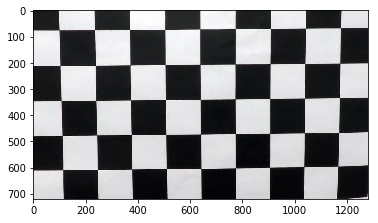

In [34]:
img=cv2.imread('./camera_cal/calibration1.jpg')
img_size=img.shape[1],img.shape[0]
cor_img=camcal.transform(img)

cv2.imwrite("test_out.png",cor_img)
plt.imshow(cor_img)
plt.show()

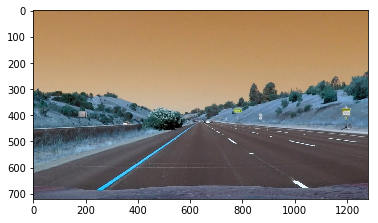

In [35]:
test_image="./test_images/straight_lines1.jpg"
img=cv2.imread(test_image)
plt.imshow(img.astype('uint8'))
plt.show()

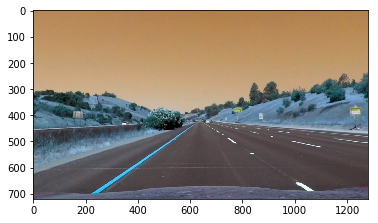

In [36]:
undist_img=camcal.transform(img)
cv2.imwrite("./test_images/straight_lines1_undistort.jpg",undist_img)
plt.imshow(undist_img)
plt.show()

## Extract threshold binary image

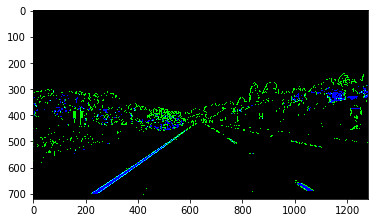

In [37]:
thres_img,single_chan_img=edge_pipeline(undist_img, s_thresh=(120, 255), sx_thresh=(30, 220))
plt.imshow(thres_img)
plt.show()

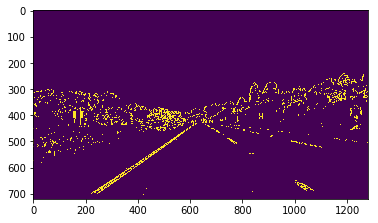

In [38]:
plt.imshow(single_chan_img)
plt.show()

In [39]:
thres_img.shape

(720, 1280, 3)

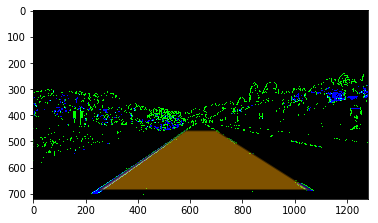

In [40]:
from matplotlib.path import Path
import matplotlib.patches as patches

verts = [
    (250, 686), # left, bottom
    (583, 458), # left, top
    (700, 458), # right, top
    (1060, 686), # right, bottom
    (250, 686), # ignored
    ]

codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

path = Path(verts, codes)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(thres_img)

patch = patches.PathPatch(path, facecolor='orange', lw=2,alpha=0.5)
ax.add_patch(patch)
plt.show()

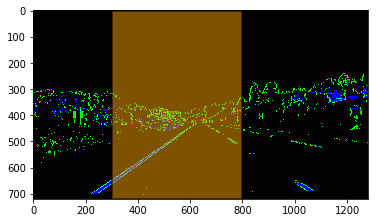

In [41]:
dest_points=[[300,720],
            [300,0],
            [800,0],
            [800,720],
            [300,720]]
path = Path(dest_points, codes)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(thres_img)

patch = patches.PathPatch(path, facecolor='orange', lw=2,alpha=0.5)
ax.add_patch(patch)
plt.show()

In [42]:
src=np.array(verts[0:-1],np.float32)
dst=np.array(dest_points[0:-1],np.float32)
#src=np.flip(src,axis=1)
#dst=np.flip(dst,axis=1)
pst=PerspectiveTransformer()
t_img=pst.transform(single_chan_img)
cv2.imwrite("./test_images/laneline_1.jpg",single_chan_img)

True

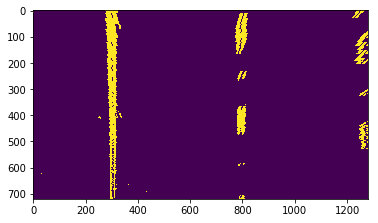

In [43]:
plt.imshow(t_img)
plt.show()

In [44]:
t_img.shape

(720, 1280)

In [45]:
leftx,lefty,left_fit,rightx,righty,right_fit,out_img,nonzerox,nonzeroy,left_lane_inds,right_lane_inds=find_lane_points(t_img)

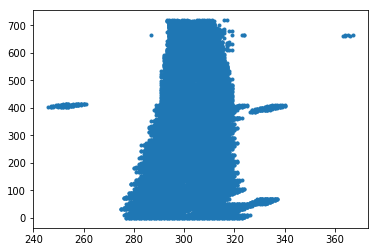

In [46]:
plt.plot(leftx,lefty,'.')

(720, 0)

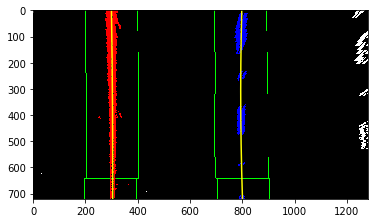

In [47]:
# Generate x and y values for plotting
ploty = np.linspace(0, t_img.shape[0]-1, t_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

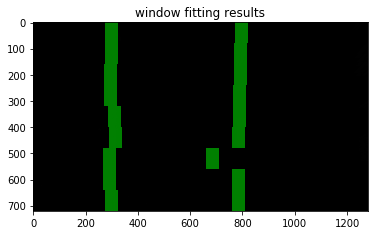

In [48]:
# Read in a thresholded image
#warped = mpimg.imread('warped_example.jpg')
warped=t_img
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

In [49]:
from sklearn.pipeline import Pipeline

In [50]:
process_pipeline=Pipeline([('cam',camcal),('undistort',EdgeExtractor()),('pers',pst)])

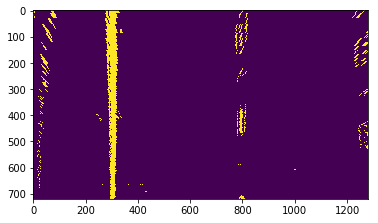

In [51]:
n_img=process_pipeline.transform(img)
plt.imshow(n_img)
plt.show()

In [52]:
# get inverse matrix
Minv=pst.get_invM()

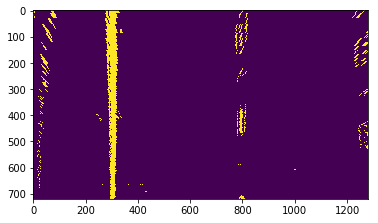

In [53]:
n_img
plt.imshow(n_img)
plt.show()

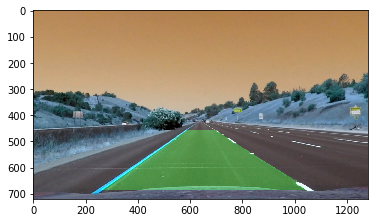

In [54]:
image=img
undist=undist_img
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

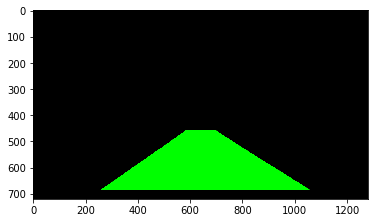

In [55]:
plt.imshow(newwarp)
plt.show()

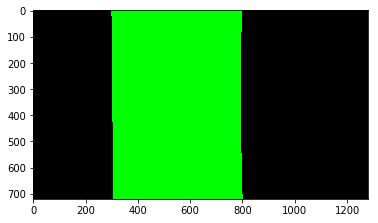

In [56]:
plt.imshow(color_warp)
plt.show()

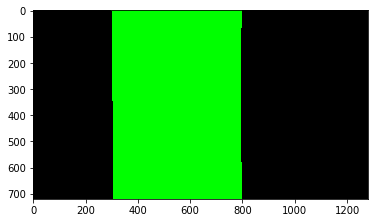

In [57]:
process_pipeline=Pipeline([('cam',camcal),('undistort',EdgeExtractor()),('pers',pst),('lane',LaneFinder())])
transformed_img=process_pipeline.fit_transform(img)
plt.imshow(transformed_img)
plt.show()

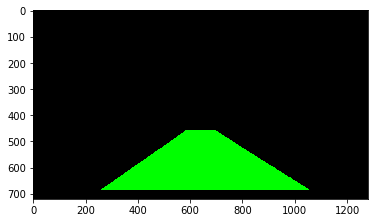

In [58]:
process_pipeline=Pipeline([('cam',camcal),('undistort',EdgeExtractor()),
                           ('pers',PerspectiveTransformer()),('lane',LaneFinder()),
                                        ('inv_pst',PerspectiveTransformer(inv_transform=True))])
transformed_img=process_pipeline.fit_transform(img)
plt.imshow(transformed_img)
plt.show()

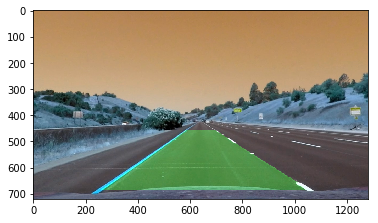

In [59]:
stacked_img=stack_lane_line(undist_img,transformed_img)
plt.imshow(stacked_img)
plt.show()

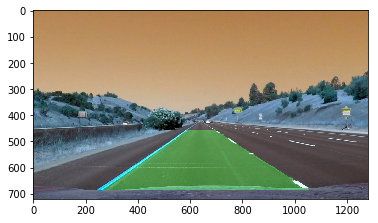

In [60]:
stacked_img=stack_lane_line(img,transformed_img)
plt.imshow(stacked_img)
plt.show()

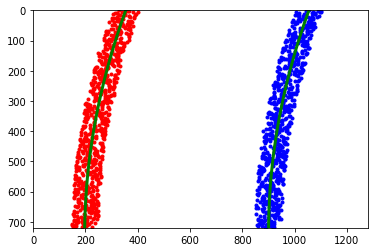

In [61]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images